In [13]:
import pandas as pd
import random
import numpy as np
import scipy
import scipy.optimize as sco
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers


The solution to this issue might depend on the solution to issue 1.  However I discovered this problem first, so I think it may be relevant to our discussion.  

Reading data

In [2]:
DJSIreturns = pd.read_csv("DJSI returns.csv").dropna(axis = 0)
DJSIquants = np.array(np.array(DJSIreturns)[:,1:], dtype = "float")

I got this code from https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/.  It calculates portfolios on the efficient frontier and one optimal portfolio, denoted with an X on the graph, using quadratic programming.

In [3]:
def optimal_portfolio(returns):  #Returns is a matrix assets, obs
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1)) #average down row
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return wt, returns, risks  # Marginal returns decreases as your risk increases!!!!

This code is modified from https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb, and it uses scipy minimize to find the portfolio weights with the minimum volatility for a given return.  

In [11]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return std, returns

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

efficients = efficient_frontier(np.mean(DJSIquants, axis=1), np.cov(DJSIquants), np.linspace(0, 0.1, 50))


My bullet is generated with the randn number generator as described in issue 1 and https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/.  However, the bullet does not quite "fit" into the efficient frontier calcuated using both methods previously described.  The dashed line refers to the scipy minimize method and the dots refer to the quadratic programming method.  I believe the dashed line becomes vertical after the optimal portfolio is found, based on the sharpe ratio, because of some mechanism I have not yet uncovered in the code.

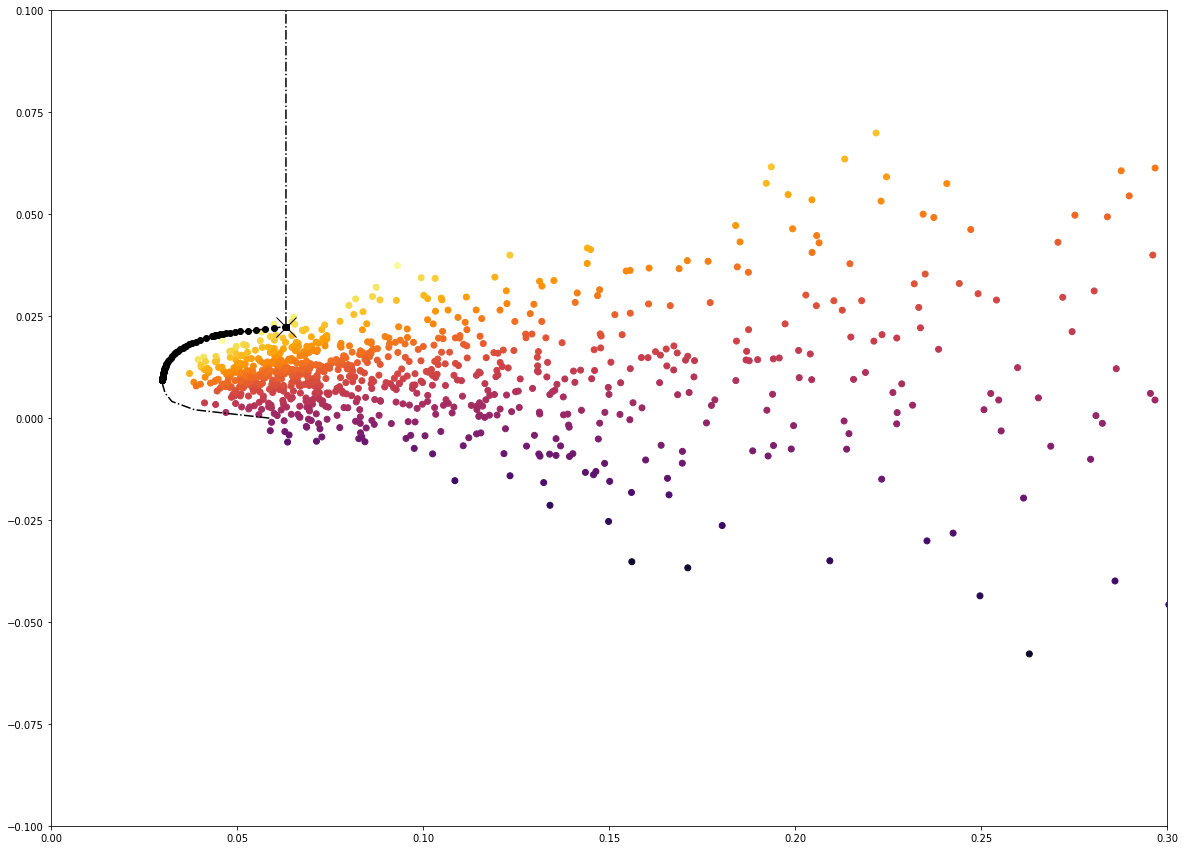

In [12]:
weights, returns, risks = optimal_portfolio(DJSIquants)

def generate_random_weights(number):
    randlist = np.random.randn(number)
    return randlist/np.sum(randlist)

random_weights = np.array([generate_random_weights(np.shape(DJSIquants)[0]) for i in range(1000)])
mean_returns = np.mean(DJSIquants, axis = 1)
covariance_returns = np.cov(DJSIquants) 

expected_returns = [np.dot(mean_returns, random_weights[i]) for i in range(1000)]
rand_risks = [np.sqrt(np.matmul(np.matmul(random_weights[i], covariance_returns),random_weights[i].T)) for i in range(1000)] 
sharpe_ratio = [expected_returns[i]/rand_risks[i] for i in range(1000)]

plt.figure(figsize = (20, 15))
plt.scatter(rand_risks, expected_returns, c = sharpe_ratio, cmap = 'inferno', marker= 'o')
plt.plot([p['fun'] for p in efficients], np.linspace(0, 0.1, 50), linestyle='-.', color='black', label='efficient frontier')
plt.plot([risks[i] for i in range(np.size(risks))], returns, 'ko')
plt.plot(np.sqrt(np.matmul(np.matmul(weights.T, covariance_returns), weights)), np.dot(mean_returns, weights), 'kx', markersize = 20)
plt.xlim(0, .3)
plt.ylim(-.1,.1)
plt.show()